# Problem description

## Problem importance 
Presentations are often used as supplementary materials in video lectures. Most of the time students do not need to watch the whole lecture while being interested only in some particular topics. Our goal is to develop a tool that will create convenient description of lecture's content. 
More precisely, the tool will process a video of a lecture to provide a user with a list of timecodes for each unique slide and those slides themselves. As a result, a user will have slides of supplementary presentation and timecodes for moments when a lecturer switches to each of those slides.

## Expected value of CV algorithm
The expected application of CV in our project is the following:
* presentation slide detection on the video frame;
* extraction and projective transformation of the slide;
* matching of slides keypoints descriptors for two consequetive frames.

## Dataset
Dataset consists of educational video lecture with supplementary presentation slides (e.g. [Generalized nonparametric method. An appendix to stock market analysis.](https://www.youtube.com/watch?v=u77WVB7mJMw&index=38&list=PLIvQImOQgbGbD1KLR4Pg_vipxuW5WeOx1)).

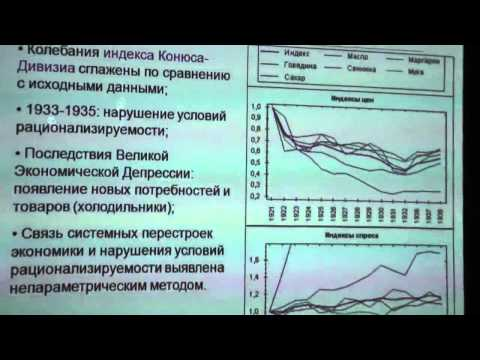

In [1]:
from IPython.display import YouTubeVideo 
YouTubeVideo("u77WVB7mJMw")

To split some video into frames in Windows we need to **install** `ffmpeg`, **create folder** `path_to_frames` and **run** `ffmpeg -i "path_to_video" -vf "select=not(mod(n\,250))" -vsync vfr "path_to_frames\\frame_%d.jpg"` command from cmd.

In [2]:
import os

In [3]:
frames_number = 0
for filename in os.listdir(path='./Frames'):
    frames_number += 1
print('Number of frames:', frames_number)

Number of frames: 696


In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def ShowImage(image, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

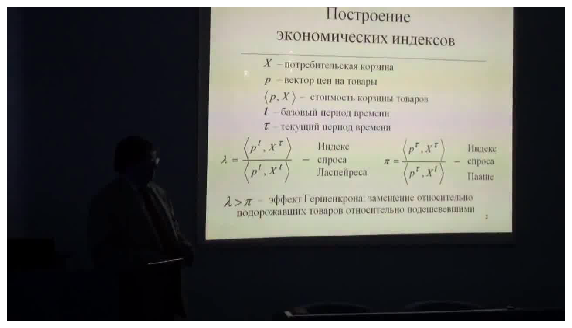

In [6]:
ShowImage(cv2.imread('./Frames/frame_12.jpg'), figsize=(10, 10))

# CV algorithm

## Description of the overall CV pipeline suitable to solve the problem.

First of all, we split the video into frames to work with images. We use ffmpeg to get every 250th frame of the video. Since it was recorded in 25 fps, we get frame for every 10 seconds of the lecture. Hence, looking at the number of the frame we can obtain its timecode. It is not a part of the CV pipeline, but this step is worth mentioning.

## CV pipeline:

**!** We consider that switching to a new subtopic is equivalent to switching a slide (with some reservations).

1. We will **cut out the slide** using **edges and angles recognition** for each frame. We do this by finding the largest rectangle on the frame.

2. We **compare sequentially** all pairs of slides to identify slide switching using **key points matching**. Comparison is performed by looking at descriptors of both consequetive slides (slides from two consequetive frames). For each descriptor on the first slide we search for the best matching descriptor on the second slide. Depending on best matches we decide whether two slides are the same or not. This is done in three different ways that we describe later.

## Our motivation for each step of the pipeline.

1. We need to extract slides because they are the only part of frames that current lecture subtopic depends on. The slides are expected to be rectangular.
2. Since we are interested in detecting changes of slides in time we have to check frame by frame until that happens. That is why we sequentially compare consequetive frames with each other.

## Slide cutting

In [7]:
from slide_extraction import DisplayPoints, FindCountour, ExtractSlide

In [8]:
frame1 = cv2.imread('./Frames/frame_10.jpg', cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread('./Frames/frame_11.jpg', cv2.IMREAD_GRAYSCALE)

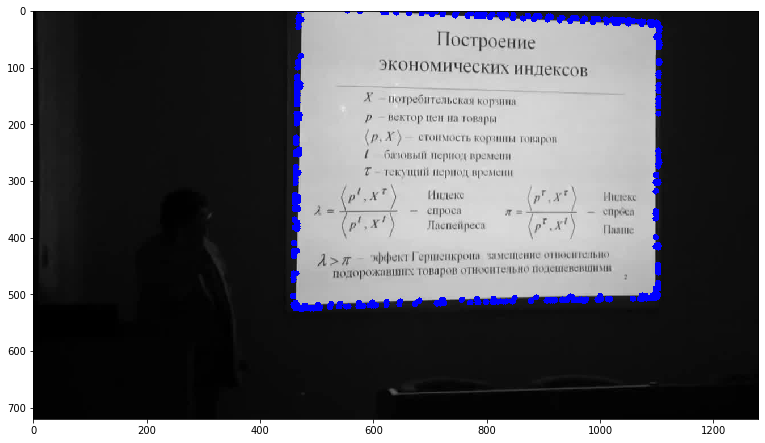

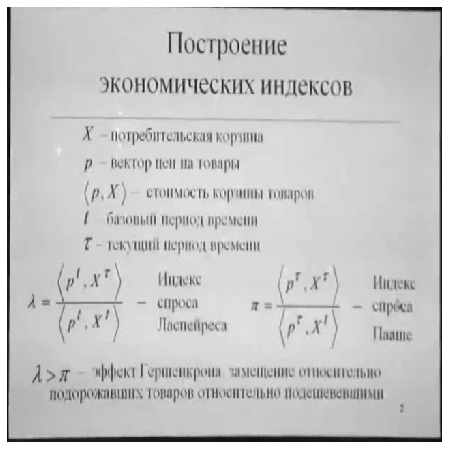

In [9]:
plt.figure(figsize=(13, 8))
contour1 = FindCountour(frame1)
DisplayPoints(frame1, contour1)
slide1 = ExtractSlide(frame1, contour1)
ShowImage(slide1, figsize=((13, 8)))

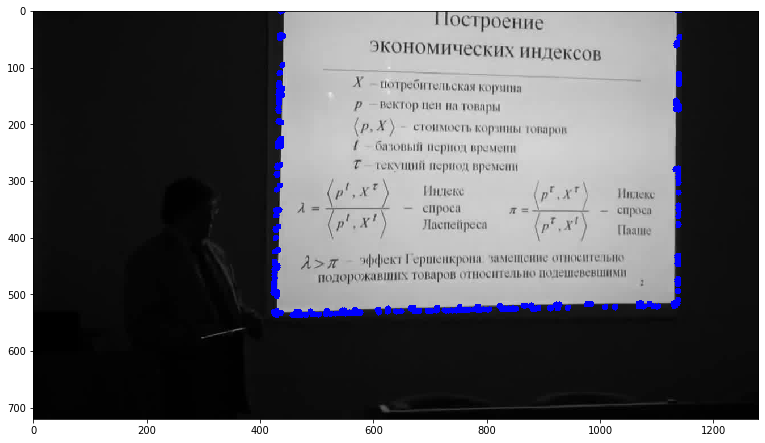

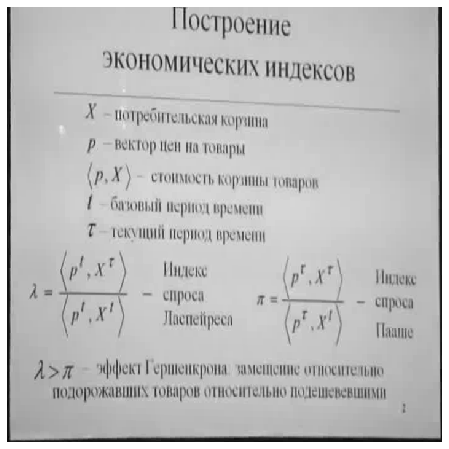

In [10]:
plt.figure(figsize=(13, 8))
contour2 = FindCountour(frame2)
DisplayPoints(frame2, contour2)
slide2 = ExtractSlide(frame2, contour2)
ShowImage(slide2, figsize=((13, 8)))

## Sequential comparison

We will compare pipelines ORB and two types of SIFT descriptors in comparison step.
* We use ORB descriptors and suppose that a descriptor from the second slide is the best match for the descriptor from first slide if it is the closest one (here and later in the sense of $L_1$-norm). Then for descriptors we look at the degree of closeness to best matches and if it is higher than empirically tuned threshold we consider that the slide has changed.

* Another way is to do the same with SIFT descriptors. 

* But the third approach that turned out to be the most accurate (leads to highest `F1-score`, described later) is to use   SIFT descriptors and do almost the same but add additional constraints for best matches. Now for each descriptor $d_1$ from the first slide we find two nearest neighbours on the second slide. The first neighbour can become the best match for it only if its distance to the $d_1$ is less than 0.75 of the distance from the second neighbour to the $d_1$. Having best matches we compute ratio of the number of best matches to the number of keypoints on both slides. Then this ratio is compared to empirically tuned threshold to decide whether the slide has changed.

The results are shown below.

In [11]:
matching_points_number = 50

### with SIFT Descriptors

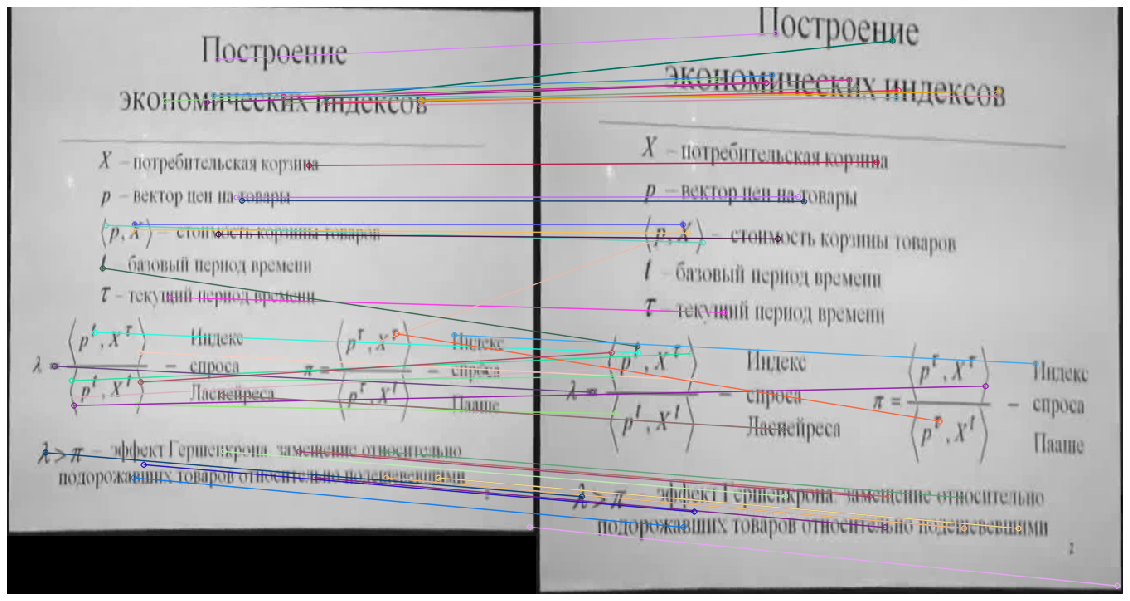

In [12]:
sift = cv2.xfeatures2d.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(slide1, None)
keypoints2, descriptors2 = sift.detectAndCompute(slide2, None)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x: x.distance)[:matching_points_number]

matching_image = cv2.drawMatches(slide1, keypoints1, slide2, keypoints2, matches, None, flags=2)
ShowImage(matching_image)

### with SIFT Descriptors and Ratio Test

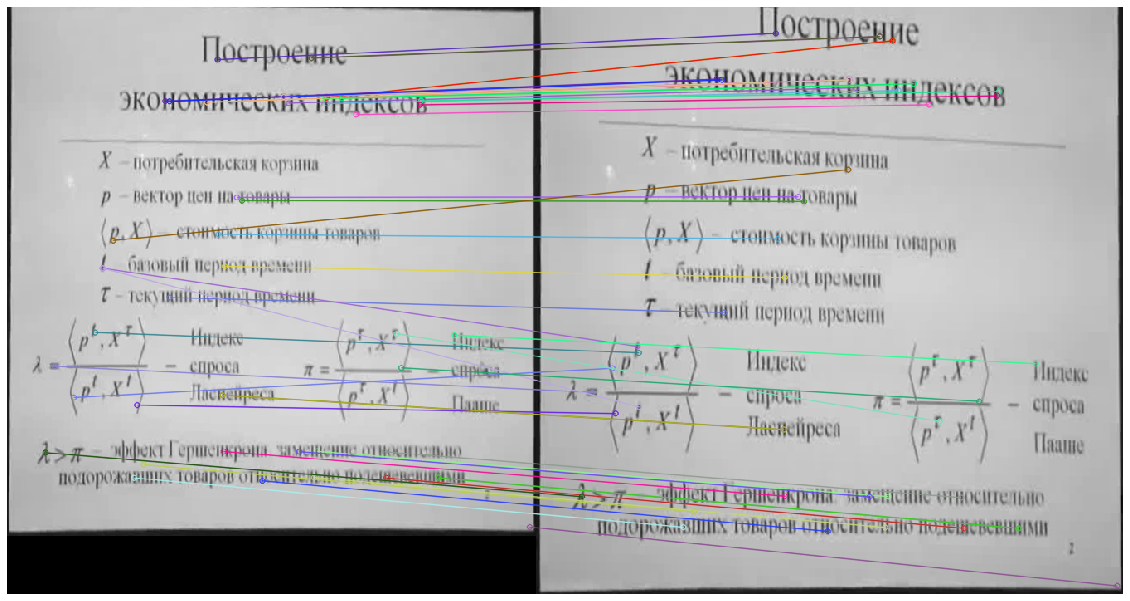

In [13]:
sift = cv2.xfeatures2d.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(slide1, None)
keypoints2, descriptors2 = sift.detectAndCompute(slide2, None)

bf = cv2.BFMatcher(cv2.NORM_L1)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# ratio test
best_matches = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        best_matches.append([m])

best_matches = sorted(best_matches, key = lambda x: x[0].distance)[:matching_points_number]

matching_image = cv2.drawMatchesKnn(slide1, keypoints1, slide2, keypoints2, best_matches, None, flags=2)
ShowImage(matching_image)

### with ORB Descriptors

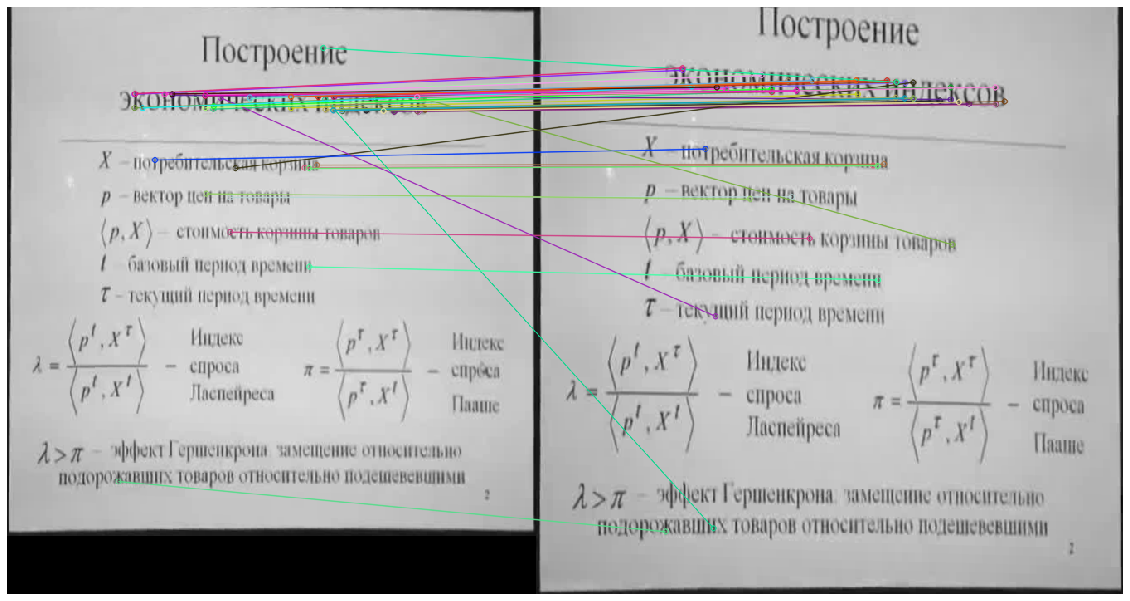

In [14]:
orb = cv2.ORB_create()

keypoints1, descriptors1 = orb.detectAndCompute(slide1, None)
keypoints2, descriptors2 = orb.detectAndCompute(slide2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x:x.distance)[:matching_points_number]

matching_image = cv2.drawMatches(slide1, keypoints1, slide2, keypoints2, matches, None, flags=2)
ShowImage(matching_image)

## CV algorithm (code)

The main code is in the files `slide_extraction.py`, `slide_matching.py` and `results.py`.

## Are the tools applied correctly?

In general the tools are applied correctly. Problem arise on the slide cutting step in cases when presentation slides are too zoomed in. That means that we can see at most one edge of the slide which is not enough for our maximum rectangle detector.

Therefore, we need to either propose another approach for cutting slides from such frames or use the whole frame for sequential comparison with the next one, or just drop these frames. We chose the latter.

# Results

## Estimation of quality metrics 
We marked all the frames by hand. Basically, we assigned each frame to one of two classes - $0$ or $1$. Class $1$ corresponds to frames on which the slide is different from the slide on the previous frame. That means, we need to store slides from such frames. Class $0$ corresponds to all other frames. Having reduced the problem to classification task we can use `F1-score` for quality estimation of compared pipelines.

## Methods comparison
Although dropping frames with zoomed in slides might lead to the loss of information it is interesting to compare main pipeline with and without such modification. The intuition is that such frames can be wrongly classified as switching slides leading to the significant loss of `F1-score` if there are many of them.
Each mentioned pipeline modification assigns label $1$ to every frame which contained switching slide which is different from the slide on the previous frame (this is determined during sequential comparison step). All other frames are labeled with $0$. With frames labeled, we compute `F1-score` and compare methods.

In [15]:
from slide_matching import GetRatio

In [16]:
def GetRatios(frames_number, slide_extraction, ratio_coeff):
    ratios = []
    frames = []
    prev_frame = cv2.imread('./Frames/frame_{}.jpg'.format(2), cv2.IMREAD_GRAYSCALE)
    for i in range(3, frames_number + 1):
        next_frame = cv2.imread('./Frames/frame_{}.jpg'.format(i), cv2.IMREAD_GRAYSCALE)
        ratio = GetRatio(prev_frame, next_frame, slide_extraction, ratio_coeff, show_matching=False)
        if ratio >= 0:
            ratios.append(ratio)
            frames.append(i)
        prev_frame = next_frame
    
    return frames, ratios

In [17]:
def ShowRatios(frames, ratios, title):
    plt.figure(figsize=(18, 13))

    plt.grid()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.title(title, fontsize=18)
    plt.xlabel('Number of frame', fontsize=18)
    plt.ylabel('Ratio', fontsize=18)
    plt.plot(frames, ratios)

In [18]:
%%time
frames_with, ratios_with = GetRatios(frames_number, slide_extraction=True, ratio_coeff=0.5)

Wall time: 7min 41s


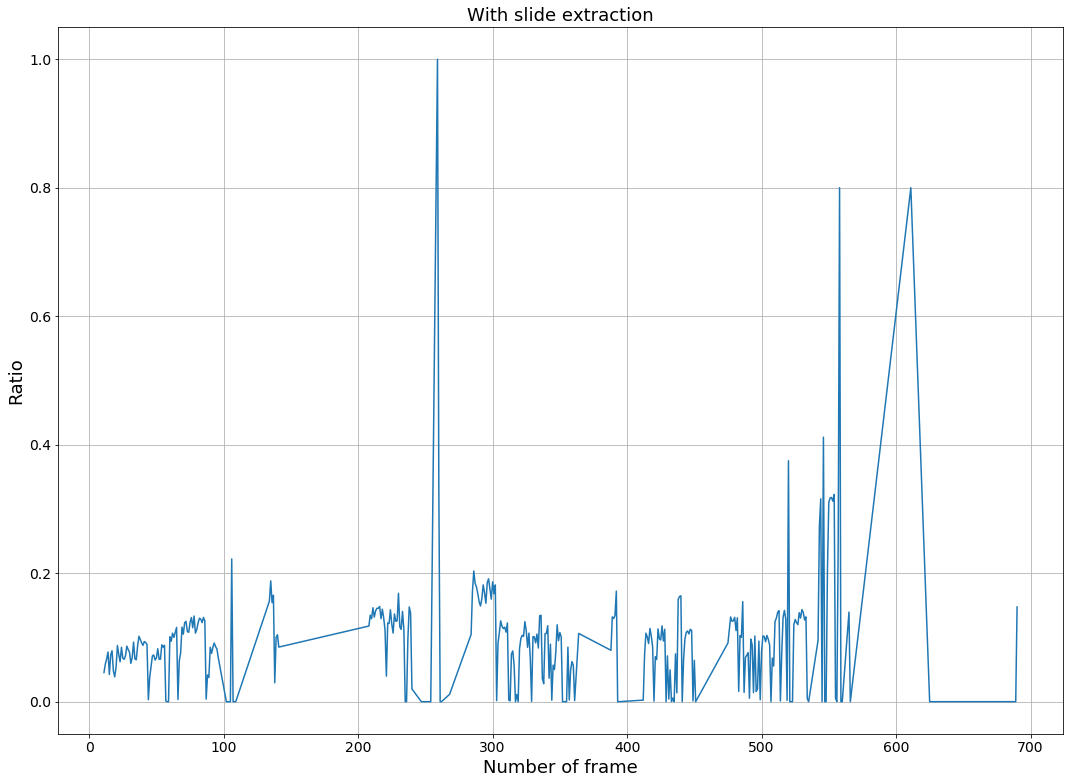

In [19]:
ShowRatios(frames_with, ratios_with, title='With slide extraction')

In [20]:
%%time
frames_without, ratios_without = GetRatios(frames_number, slide_extraction=False, ratio_coeff=0.5)

Wall time: 13min 30s


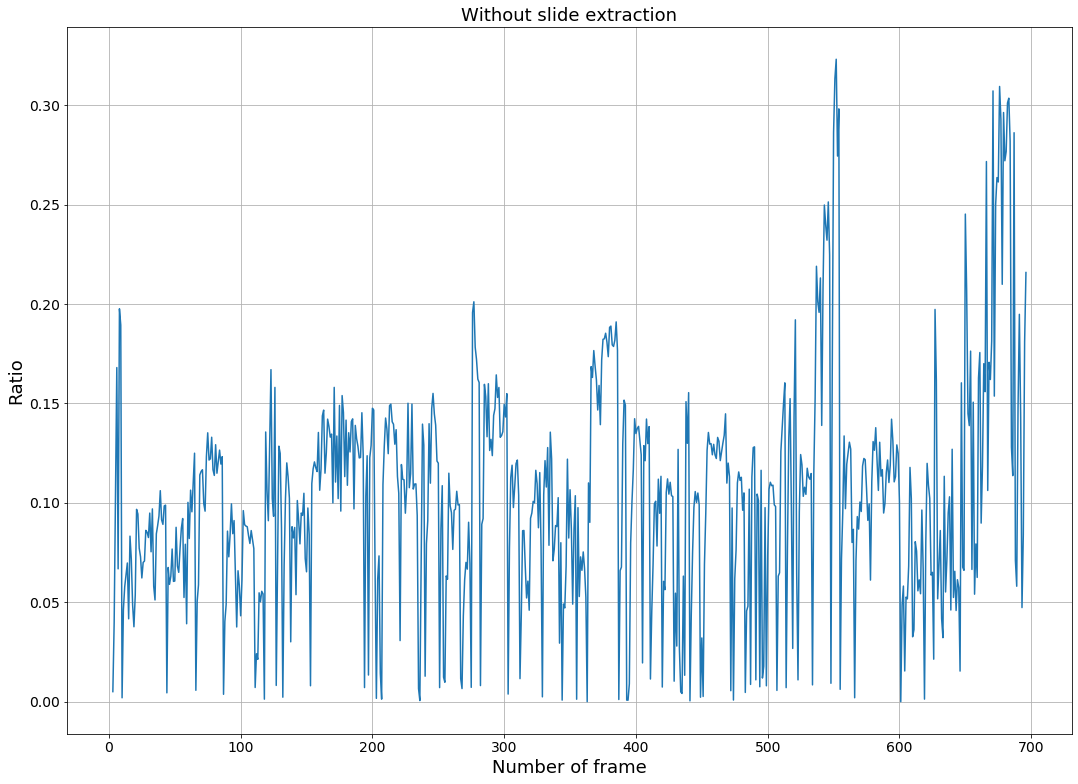

In [21]:
ShowRatios(frames_without, ratios_without, title='Without slide extraction')

In [22]:
import numpy as np
from results import ExtractionFromExcel, GetClasses, PrecisionRecall

In [23]:
switch_slides = ExtractionFromExcel(path='./MarkedSlides.xlsx')
test = GetClasses(switch_slides, np.full(len(switch_slides), 0), frames_number, threshold=1)

In [24]:
threshold_with = 0.03
pred_with = GetClasses(frames_with, ratios_with, frames_number, threshold_with)

In [25]:
threshold_without = 0.025
pred_without = GetClasses(frames_without, ratios_without, frames_number, threshold_without)

With slide extraction
Average precision-recall score: 0.37
F1 score: 0.5714285714285714


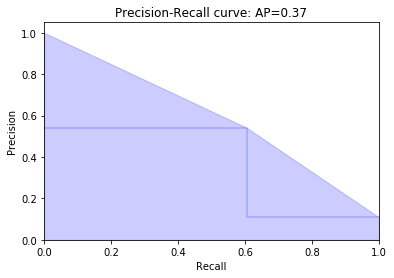

In [26]:
PrecisionRecall(test, pred_with, title='With slide extraction')

Without slide extraction
Average precision-recall score: 0.76
F1 score: 0.861111111111111


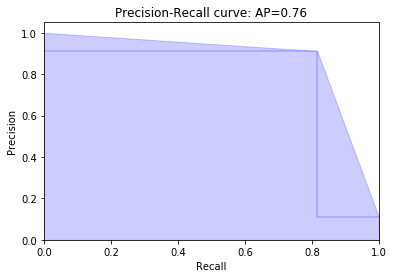

In [27]:
PrecisionRecall(test, pred_without, title='Without slide extraction')

## The obtained results

In [28]:
from results import PredictionToTimecodes

In [29]:
timecodes = PredictionToTimecodes(test)
print('Obtained timecodes are:')
print(timecodes)

Obtained timecodes are:
['0:00:10', '0:01:30', '0:07:10', '0:09:20', '0:09:30', '0:10:50', '0:14:20', '0:18:20', '0:19:30', '0:21:00', '0:21:50', '0:22:50', '0:25:20', '0:32:10', '0:32:40', '0:33:40', '0:34:20', '0:36:40', '0:39:00', '0:39:10', '0:39:50', '0:41:40', '0:42:10', '0:42:20', '0:44:20', '0:44:30', '0:45:40', '0:46:50', '0:50:20', '0:51:50', '0:52:40', '0:52:50', '0:54:40', '0:56:00', '0:56:10', '0:57:10', '0:59:00', '1:00:10', '1:00:20', '1:00:40', '1:04:20', '1:05:20', '1:05:30', '1:05:40', '1:07:20', '1:08:20', '1:09:50', '1:11:20', '1:11:40', '1:12:00', '1:12:10', '1:12:20', '1:12:40', '1:13:20', '1:14:40', '1:15:00', '1:18:30', '1:18:50', '1:20:20', '1:21:00', '1:21:40', '1:22:10', '1:22:30', '1:22:40', '1:23:00', '1:24:20', '1:25:30', '1:26:20', '1:27:00', '1:28:50', '1:31:10', '1:32:20', '1:34:10', '1:40:00', '1:43:00', '1:44:10']


## Bad examples
On the image you can see an example of bad frame. It is bad because we can not detect slide by finding the largest rectangular and our slide cutting algorithm fails causing failure on the next step. We can improve it by using another approach to finding slides on the frame. That can be done by using text detecting algorithms (e.g. EAST from OpenCV) and choosing the bounding box around the whole text as a slide.

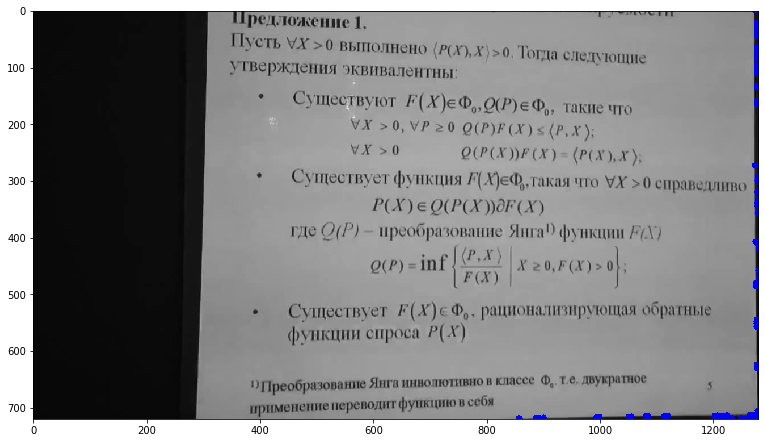

In [30]:
frame = cv2.imread('./Frames/frame_109.jpg', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(13, 8))
contour = FindCountour(frame)
DisplayPoints(frame, contour)